In [8]:
# import the necessary packages
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import numpy as np
import colorsys
import argparse
import random
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
# Load the class label names from coco labels
CLASS_NAMES = open("coco_labels.txt").read().strip().split("\n")
display_class_name = ""
for class_name in CLASS_NAMES:
    display_class_name += class_name + " | "
print("Found {:d} classes: ".format(len(CLASS_NAMES)), display_class_name)

Found 81 classes:  BG | person | bicycle | car | motorcycle | airplane | bus | train | truck | boat | traffic light | fire hydrant | stop sign | parking meter | bench | bird | cat | dog | horse | sheep | cow | elephant | bear | zebra | giraffe | backpack | umbrella | handbag | tie | suitcase | frisbee | skis | snowboard | sports ball | kite | baseball bat | baseball glove | skateboard | surfboard | tennis racket | bottle | wine glass | cup | fork | knife | spoon | bowl | banana | apple | sandwich | orange | broccoli | carrot | hot dog | pizza | donut | cake | chair | couch | potted plant | bed | dining table | toilet | tv | laptop | mouse | remote | keyboard | cell phone | microwave | oven | toaster | sink | refrigerator | book | clock | vase | scissors | teddy bear | hair drier | toothbrush | 


In [3]:
# generate random (but visually distincit colors for each class label)
hsv = [(i / len(CLASS_NAMES), 1, 1.0) for i in range(len(CLASS_NAMES))]
COLORS = list(map(lambda c:colorsys.hsv_to_rgb(*c), hsv))
random.seed(42)
random.shuffle(COLORS)

In [7]:
class SimpleConfig(Config):
    # give the configuration a recognizable name
    NAME = "coco_inference"
    
    # set the umber of GPUs to use along with the number of images
    GPU_count = 1 
    IMAGES_PER_GPU = 1
    
    # number of classes: we woudld normally add +1 for the background
    # but the background calss is *already* included in the class names
    NUM_CLASSES = len(CLASS_NAMES)
    
# initialize the inference configuration
config = SimpleConfig()

# initialize the Mask R-CNN model with pretrained weight
print("[INFO] Loading Mask R-CNN mode... ")
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=os.getcwd())
model.load_weights("mask_rcnn_coco.h5",by_name=True)


[INFO] Loading Mask R-CNN mode... 


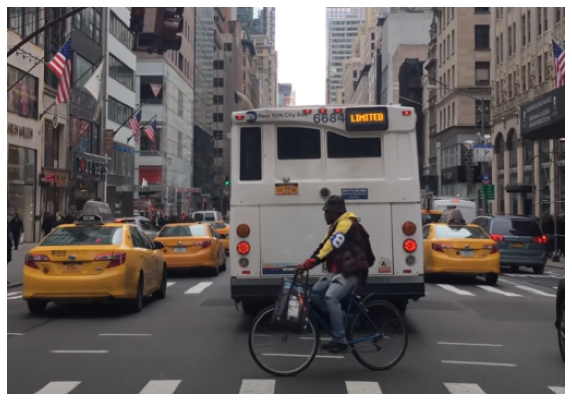

In [5]:
# visualize testing image
def resize(image, width):
    h,w = image.shape[:2]
    ratio = h/w
    image_resize = cv2.resize(image,(width, int(ratio*width)))
    return image_resize

image = cv2.imread("images/image_1.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = resize(image,(512))
plt.figure(figsize=(10,8))
plt.axis(False)
plt.imshow(image)

[INFO] making predictions with Mask R-CNN...
Processing 1 images
image                    shape: (355, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


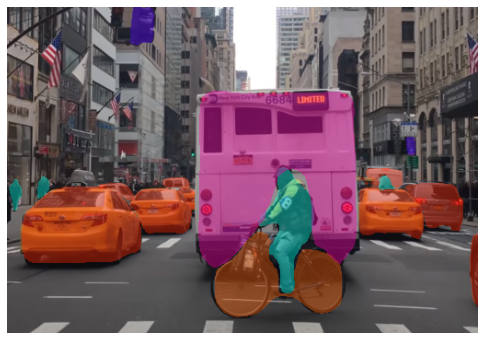

In [9]:
# predict segmenting area and visualie result

def segmenting_image(image, segmenting_objects, model):
    print("[INFO] making predictions with Mask R-CNN...")
    img = image.copy()
    r  = model.detect([img],verbose=1)[0] 
    
    # loop over the detected object's bounding boxes and mask
    for i in range(0,r["rois"].shape[0]):
        # extract the class ID and mask for the current detection,
        # thengrab the color to visualuze the mask (in BGR format)
        classID = r["class_ids"][i]
        if CLASS_NAMES[classID] not in segmenting_objects: continue
        mask = r["masks"][:, :, i]
        color = COLORS[classID][::-1]

        # visualize the pixel-wise mask of the object
        img =  visualize.apply_mask(img, mask, color, alpha=0.4)
    return img
                       
# indicated desired segmenting objects
segmenting_objects= ["person", "bicycle","car", "motorcycle","bus",
                     "train","truck","traffic light", "stop sign"]                      
plt.figure(figsize=(10,6))
plt.axis(False)
display_img = segmenting_image(image,segmenting_objects,model)
plt.imshow(display_img)      
#plt.savefig("segmented_image.jpg", dpi=300)

In [ ]:
# testing on video

cap = cv2.VideoCapture("test_video_2.mp4")
_, frame = cap.read()

# saving processed frame as video
#video_size = (512,288)
#writer = cv2.VideoWriter("segmenting_video.mp4",cv2.VideoWriter_fourcc(*'DIVX'),24,video_size)

while True:
    _, frame = cap.read()
    if frame is None: break
    
    frame = resize(frame,(512))
    frame = segmenting_image(frame,segmenting_objects,model)
    cv2.imshow("Segmenting", frame)
#     writer.write(frame)
    key = cv2.waitKey(1) or 0xff
    if key == 27:
        break
        
cap.release()   
writer.release()
cv2.destroyAllWindows()     

### Visualize result
<br>
<p align="center"><img src="segmenting_result.gif" width=640></p> 

## The End!